In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [3]:
images = np.load("data/images.npy")

In [4]:
images.shape

(2000, 28, 28)

In [5]:
# Normalise image data between 0 and 1
images = images/np.max(images)

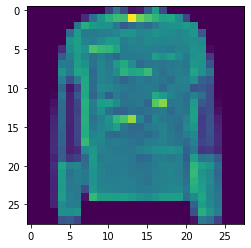

In [6]:
plt.imshow(images[700])

In [7]:
# flatten each image to a row vector
def flatten_images(images: list) -> list:
    flattened_images = []
    for image in images:
        flattened_images.append(image.flatten())
    return np.array(flattened_images)
flat_images = flatten_images(images)

<h3> Total Variance Captured </h3>

In [8]:
total_var_pca = np.zeros(9)
for i in range(1, 10):
    pca_i = PCA(n_components=i**2)
    pca_i.fit(flat_images)
    total_var_pca[i-1] = pca_i.explained_variance_ratio_.sum()

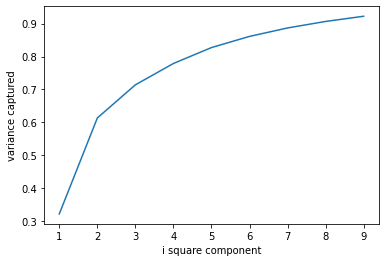

In [9]:
plt.ylabel("variance captured")
plt.xlabel("i square component")
plt.plot(np.arange(1, 10), total_var_pca)
plt.show()

In [10]:
# use PCA to achieve image reduction
pca = PCA(n_components=16, whiten=True)  # using 16 components, so we have 4x4 for each image
reduced_images = pca.fit_transform(flat_images)

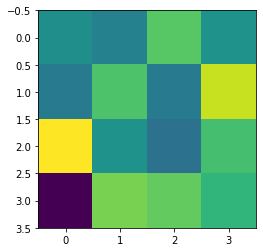

In [11]:
plt.imshow(reduced_images[10].reshape(4,4))

In [12]:
reduced_images[10]

array([-0.30856706, -0.66432543,  1.15536046, -0.2240795 , -0.83931143,
        1.02554116, -0.82355332,  2.20870558,  2.73052617, -0.23198195,
       -1.05240384,  0.93954039, -3.3468985 ,  1.51322298,  1.26817184,
        0.66258554])

In [13]:
reduced_images.shape

(2000, 16)

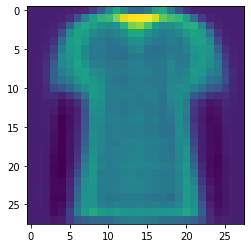

In [14]:
# map back from lower space to original space
plt.imshow(pca.inverse_transform(reduced_images).reshape(2000, 28, 28)[100])

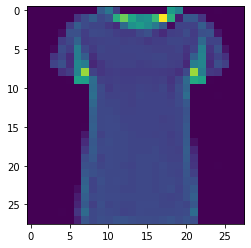

In [15]:
plt.imshow(images[100])

In [16]:
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import TwoLocal

In [17]:
TRAIN_DATA = reduced_images
TRAIN_LABELS = [int(x) for x in np.load('data/labels.npy')]

In [18]:
TRAIN_DATA = []
for image in reduced_images:
    scaler = MinMaxScaler()
    scaler.fit(image.reshape(-1,1))
    normalised = scaler.transform(image.reshape(-1,1))
    normstate = [float(x) for x in normalised]
    TRAIN_DATA.append([np.pi*n for n in normstate])

In [22]:
from qiskit.circuit.library import TwoLocal
# Parametrize input data
qubit_num = 16
theta_list = ParameterVector('th', length=qubit_num)

FEATURE_MAP = QuantumCircuit(qubit_num)
#for i in range(len(normalised)):
   # theta_list[i] = np.pi*float(normalised[i])
for i in range(len(theta_list)):
    FEATURE_MAP.ry(theta_list[i], i)

#Set up PQC 
PQC = TwoLocal(qubit_num, ['rx', 'rz'], 'cz', reps=2)

NEW_CIRCUIT = FEATURE_MAP.compose(PQC)
NEW_CIRCUIT.measure_all()
#NEW_CIRCUIT.decompose().draw()

In [42]:
def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(list(theta_list)):
        parameters[p] = data[i]
    for i, p in enumerate(PQC.ordered_parameters):
        parameters[p] = variational[i]
    return NEW_CIRCUIT.assign_parameters(parameters)

In [43]:
def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

In [44]:
def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

In [45]:
from qiskit import BasicAer, execute

def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classification = [
        label_probability(results.get_counts(c)) for c in circuits]
    return classification

In [46]:
def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

In [ ]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
        print(evaluation)

# Set up the optimization
from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

initial_point = np.random.random(PQC.num_parameters)
#initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                        #  0.88372228, 4.08885928, 2.45568528,
                         # 4.92364593, 5.59032015, 3.66837805,
                          #4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [26]:
def _encoding(images):
    encoded_images = []
    for image in images:
        qc = QuantumCircuit(16,16)
        # Normalise data in image (might have to save normalisation to inverse later)
        
        scaler = MinMaxScaler()
        scaler.fit(image.reshape(-1,1))
        normalised = scaler.transform(image.reshape(-1,1))
        
        for i in range(len(normalised)):
            qc.ry(np.pi*float(normalised[i]), i)
            
        qc.measure(np.arange(0,16,1),np.arange(0,16,1))
        encoded_images.append(qc)
    return encoded_images

In [27]:
encoded_images = _encoding(reduced_images)

In [28]:
encoded_images[10].draw()

┌────────────┐┌─┐                                             
 q_0: ┤ Ry(1.5674) ├┤M├─────────────────────────────────────────────
      ├────────────┤└╥┘┌─┐                                          
 q_1: ┤ Ry(1.3831) ├─╫─┤M├──────────────────────────────────────────
      ├────────────┤ ║ └╥┘┌─┐                                       
 q_2: ┤ Ry(2.3257) ├─╫──╫─┤M├───────────────────────────────────────
      ├────────────┤ ║  ║ └╥┘┌─┐                                    
 q_3: ┤ Ry(1.6111) ├─╫──╫──╫─┤M├────────────────────────────────────
      ├────────────┤ ║  ║  ║ └╥┘┌─┐                                 
 q_4: ┤ Ry(1.2925) ├─╫──╫──╫──╫─┤M├─────────────────────────────────
      ├────────────┤ ║  ║  ║  ║ └╥┘┌─┐                              
 q_5: ┤ Ry(2.2584) ├─╫──╫──╫──╫──╫─┤M├──────────────────────────────
      ├────────────┤ ║  ║  ║  ║  ║ └╥┘┌─┐                           
 q_6: ┤ Ry(1.3006) ├─╫──╫──╫──╫──╫──╫─┤M├───────────────────────────
      ├────────────┤ ║  ║  ║  ║  ║  ║ └╥┘┌─┐                        
 q_7: ┤ Ry(2.8712) ├─╫──╫──╫──╫──╫──╫──╫─┤M├────────────────────────
      └─┬───────┬──┘ ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                     
 q_8: ──┤ Ry(π) ├────╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────
      ┌─┴───────┴──┐ ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                  
 q_9: ┤ Ry(1.6074) ├─╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────
      ├────────────┤ ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐               
q_10: ┤ Ry(1.1827) ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────
      ├────────────┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐            
q_11: ┤ Ry(2.2161) ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────
      └─┬───────┬──┘ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐         
q_12: ──┤ Ry(0) ├────╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────
      ┌─┴───────┴──┐ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
q_13: ┤ Ry(2.5063) ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────
      ├────────────┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
q_14: ┤ Ry(2.3753) ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
      ├────────────┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_15: ┤ Ry(2.0544) ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
      └────────────┘ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
c: 16/═══════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                     0  1  2  3  4  5  6  7  8  9  10 11 12 13 14 15

<h3> simulating and plotting histogram </h3>

In [303]:
from qiskit.visualization import plot_histogram
from qiskit import Aer, transpile

In [304]:
len(encoded_images)

2000

In [363]:
#tmp_img.measure_all()
simulator = Aer.get_backend('aer_simulator')
#tmp_img = transpile(tmp_img, simulator)

shot_num = 10000

#index each qubit in the binary number
num = 16
decoded = []
for i in range(len(encoded_images)):
    amplist = np.zeros(16)
    tmp_img = encoded_images[i]
    result = simulator.run(tmp_img, shots=shot_num).result()
    counts = result.get_counts(tmp_img)
    keys = list(counts.keys())
    for k in range(len(keys) - 1):
            binlist = [int(d) for d in str(keys[k])]
            amplist = amplist + [x * counts[keys[k]]/shot_num for x in binlist]
    
    decoded.append(amplist)
#plot_histogram(counts, title='Bell-State counts')

In [364]:
decoded[10]

array([0.7452, 0.8537, 0.9024, 0.    , 0.8002, 0.3101, 0.5191, 0.9999,
       0.983 , 0.3652, 0.815 , 0.3643, 0.5307, 0.8461, 0.4139, 0.4913])

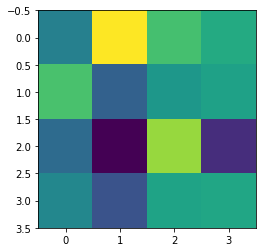

In [343]:
plt.imshow(reduced_images[700].reshape(4,4))

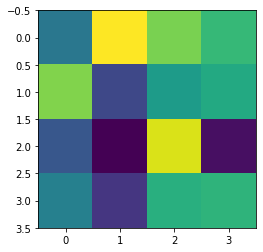

In [344]:
plt.imshow(np.rot90(amplist.reshape(4,4),2))

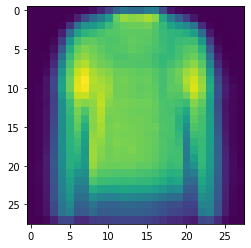

In [370]:
plt.imshow(pca.inverse_transform(decoded).reshape(2000, 28, 28)[100])

In [346]:
keys = list(counts.keys())
range(len(keys))
[int(d) for d in str(int(keys[4]))]
amplist = np.zeros(16-1)
[int(d) for d in str(keys[4])]

[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]

<h3> Decoding </h3>